In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as stats
import numpy as np
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.interpolate
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import math
from astropy import units as u
from astropy.constants import k_B as kb
import time
from scipy.optimize import minimize_scalar
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

In [4]:
T = 30
uam= 1.6605390666e-27
m=40

k_B = kb.value
k_B = 1

gen = np.random.default_rng(2023)

In [5]:
def fe(e, T):
    beta = 1/(T*k_B)
    A=np.sqrt(beta/np.pi)
    return A/np.sqrt(e)*np.exp(-beta*e)

def exp_val(e, T):
	return e*fe(e,T)

def Gaussian(x, mu, s):
    C = 1/(np.sqrt(2*np.pi)*s)
    return C*np.exp(-(x-mu)*(x-mu)/(2*s*s))

def moment_2(e, T):
	return e*e*fe(e,T)

Task-1

a. We want to demonstrate that $f(E_{\omega})$ is a PDF. To do so we must find the normalization constant $A$ for any temperature, and show that $f$ is positive. The second part is easy and will be demonstrate in the report. We can proove that the normalization is $\sqrt{\frac{\beta}{\pi}}$ numerically by integrate the function $f$ over the energy space, for different temperature and check that the given result is close to $1$

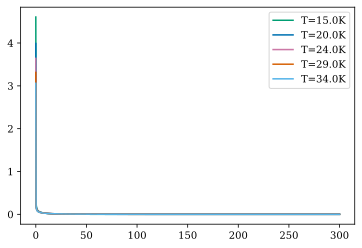

In [6]:
E = np.linspace(1e-3, 300, 1000)
t = np.linspace(5, 50, 30)
for i in range(5):
    plt.plot(E, fe(E, round(t[i]*3)), label=f'T={round(t[i]*3)}K')   
# plt.yscale('log')
plt.legend()

In [7]:
Norms = np.empty(len(t), dtype=object)

for i in range(len(Norms)):
    Norms[i] = integrate.quad(lambda eps: fe(eps, t[i]), 0, np.inf, epsrel = 1e-5)[0]

n_1 = 1/Norms

In [8]:
I = integrate.quad(fe, 0, np.inf, args =(T), epsrel = 1e-5)[0]
ExpVal = integrate.quad(exp_val, 0, np.inf, args =(T), epsrel = 1e-5)[0]
varPDF = integrate.quad(moment_2, 0, np.inf, args =(T), epsrel = 1e-5)[0]-ExpVal**2
mean_th = 1/2*k_B*T
corrFac = mean_th/ExpVal
delta   = (k_B*T)/(2*corrFac)
gamma   = (3/(5*corrFac))

print(  " The integral of f:\t" ,  I 
        ,"\n The exp.value: \t" , ExpVal
        , "\n The theoretical :\t", mean_th
        , "\n The variance  :\t", varPDF
        , "\n Mean Th after corr:\t", mean_th/corrFac)

 The integral of f:	 1.0000000000233806 
 The exp.value: 	 15.000000061237072 
 The theoretical :	 15.0 
 The variance  :	 449.9999981587827 
 Mean Th after corr:	 15.000000061237072


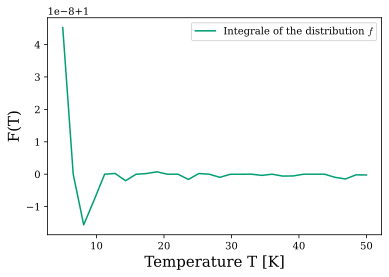

In [9]:
plt.plot(t, n_1, label='Integrale of the distribution $f$')
plt.xlabel("Temperature T [K]")
plt.ylabel("F(T)")
plt.legend()

b. Now we will build a MC process and verivy that the data set is correct.

In [10]:
def E_generator_plus(ninput, temp=30, nbins = 50):
    xinterval=(1e-3, 200)
    max=fe(1e-3, temp)
    fmax=max+0.02*max
    x_output=list(range(ninput))
    y_output=list(range(ninput))
    
    x_rejected=[]
    y_rejected=[]
    ii=0
    ir=0

    while ii<ninput:
        rx=np.random.uniform(xinterval[0],xinterval[1])
        ry=1/rx*np.random.uniform(0,1)

        if ry<fe(rx, temp):
            x_output[ii]=rx
            y_output[ii]=ry
            ii+=1
        else:
            x_rejected.append(rx)
            y_rejected.append(ry)
            ir+=1
    return x_output, y_output, x_rejected, y_rejected

def E_generator(ninput, temp=30):
    xinterval=(1e-3, 150)
    x_output=list(range(ninput))
    ii=0
    max=fe(1e-3, temp)
    fmax=max+0.02*max  

    while ii<ninput:
        rx=np.random.uniform(xinterval[0],xinterval[1])
        ry=np.random.uniform(0,fmax)

        

        if ry<fe(rx, temp):
            x_output[ii]=rx
            ii+=1
    return x_output

def E_generator_2(ninput, temp=30):
    xinterval=(1e-3, 150)
    max=fe(1e-3, temp)
    fmax=max+0.02*max 

    x_output=np.array([])
    ii=0

    while ii<ninput:

        x = gen.uniform(*xinterval, ninput)
        y = gen.uniform(0, fmax, ninput)
        accepted = (y <= fe(x, temp))
        x_accepted = x[accepted]
        x_output = np.append(x_output, x_accepted)
        x_output=x_output.flatten()
        ii+=len(x_accepted)

    x_output = x_output[:ninput]

    return x_output

def Weight(nbins, Datas, n_sample):

    weigth_accepted = 1/Datas**(1/2)*nbins/n_sample

    return weigth_accepted

In [11]:
DataSet = E_generator_2(1000000, T)
print(len(DataSet))

1000000


c. The theoritical expectation value is a bit lower because the Pdf should be taken from 0 but sinc the pdf is not define in this point building a montecarlo in this range is not possible

In [12]:
Expectation_th = 1/2*k_B*T
Expectation_sim = np.mean(DataSet)
print(Expectation_sim, Expectation_th)

14.849327224150493 15.0


Text(0, 0.5, '# Data points')

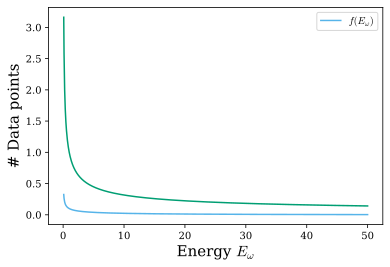

In [13]:
# plt.scatter(DataSet[0], DataSet[1], label='Accepted data', s=1, c=myColors[1])
# plt.scatter(DataSet[2], DataSet[3], label='Rejected data', s=1, c=myColors[2])
x = np.linspace(0.1, 50, 1000)
f =fe(x, T)
plt.plot(x, f, label='$f(E_{\omega})$', c=myColors[4])   
# plt.plot((0, 300), (fe(1e-3, T), fe(1e-3, T)), label = 'Uniform envelope')
plt.plot(x, 1/(x)**(1/2))
plt.legend(loc=1)
plt.xlabel('Energy $E_{\omega}$')
plt.ylabel('# Data points')
# plt.xlim(0, 0.1)
# plt.ylim(0,1)

In [14]:
datas = np.array(DataSet)
datas = datas[datas<30]


Text(0, 0.5, '# Data points')

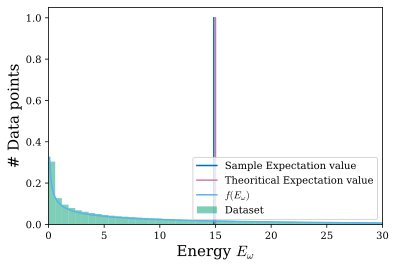

In [15]:
bin_entries, bin_edges, _ = plt.hist(datas,50, alpha=0.5, label='Dataset', density=True)
plt.plot((Expectation_sim, Expectation_sim), (0, 1), label = 'Sample Expectation value')
plt.plot((Expectation_th, Expectation_th), (0, 1), label = 'Theoritical Expectation value')
plt.plot(x, f, label='$f(E_{\omega})$', c=myColors[4])   
plt.legend()
plt.xlim(0, 30)
# plt.ylim(0, 0.2)
plt.xlabel('Energy $E_{\omega}$')
plt.ylabel('# Data points')

<ipython-input-16-13ffb1ebb1c2>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)


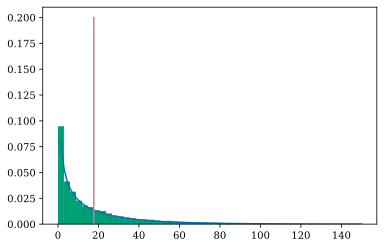

In [16]:
import random

def f(e, beta):
    return np.sqrt(beta/np.pi)/np.sqrt(e)*np.exp(-beta*e)

def proposal_distribution(e_min, e_max):
    return random.uniform(e_min, e_max)

# Set the value of beta
T = 30 # K
beta = 1/T

# Set the limits of the proposal distribution
e_min = 0
e_max = 150

# Set the number of samples to generate
n_samples = 10000

# Initialize an empty list to store the samples
samples = []

i=0
# Generate the samples
while i<n_samples:
    e = proposal_distribution(e_min, e_max)
    importance_weight = f(e, beta) / proposal_distribution(e_min, e_max)
    if random.uniform(0, 1) < importance_weight:
        samples.append(e)
        i+=1

plt.hist(samples, density=True, bins=50)
x = np.linspace(e_min, e_max, 100)
plt.plot(x, f(x, beta))
plt.plot((np.mean(samples), np.mean(samples)), (0, 0.20))

In [17]:
np.mean(samples)

17.724976135384733

In [18]:
from scipy.stats import skew
from scipy.stats import kurtosis

s = skew(DataSet)
k = kurtosis(DataSet)
print(s, k)

2.4159153207535233 7.254475964855603


Task-2 
a. Law of large number

In [19]:
DataSet_LLN = DataSet

In [21]:
N=len(DataSet_LLN)
list_ntest = np.around(0.5*np.logspace(1, int(np.log10(N)), 500))
list_Average = np.empty(len(list_ntest), dtype=object)
l = len(list_ntest)
for i in range(l):
    moy = np.mean(DataSet_LLN[:int(list_ntest[i])])
    list_Average[i] = moy

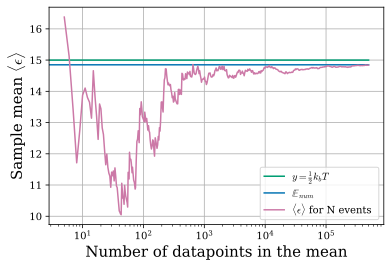

In [22]:
N=int(list_ntest[-1])
plt.plot([0,N],[1/2*T,1/2*T],  label = r"$y = \frac{1}{2}k_bT$")
plt.plot([0,N],[Expectation_sim,Expectation_sim], label = r"$\mathbb{E}_{num}$")
plt.plot(list_ntest, list_Average, label = r"$\langle\epsilon\rangle $ for N events ")

plt.xlabel("Number of datapoints in the mean")
plt.ylabel(r"Sample mean $\langle\epsilon\rangle$")
plt.legend()
plt.grid()
plt.xscale('log')

b. We want to compute the variance of $x = \sqrt{2E_{\omega}/m\omega^2}$ 

In [23]:
def x(E, omega=1):
    return np.sqrt(2*E/(m*omega**2))

c. Central limit theorem

In [24]:
n_exp = 1000
n_sample = [500, 1000]

means_E_CLT = np.empty(len(n_sample), dtype=object)
vars_E_CLT = np.empty(len(n_sample), dtype=object)


for i in range(len(n_sample)):
    mean_E = np.empty(n_exp, dtype=object)
    var_E = np.empty(n_exp, dtype=object)
    n=0
    while n<n_exp:
        E_dataset = E_generator_2(n_sample[i], T)
        mean_E[n] = np.mean(E_dataset)
        var_E[n] = np.var(E_dataset)
        n+=1
    
    means_E_CLT[i] = mean_E
    vars_E_CLT[i] = var_E

The variance of the mean is  0.9486832961097004 0.6708203918775746


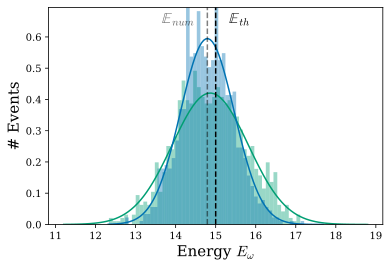

In [25]:
Fig, bx = plt.subplots(figsize=(6,4))


Means_CLT = np.empty(len(n_sample), dtype=object)
sigma_CLT = np.empty(len(n_sample), dtype=object)
plot_max = 0
for i in range(len(n_sample)):
    Means_CLT[i] = np.mean(means_E_CLT[i])
    sigma_CLT[i] = np.sqrt(varPDF/(n_sample[i]))
    efit = np.linspace(ExpVal-4*sigma_CLT[i], ExpVal+4*sigma_CLT[i], 100)
    G = Gaussian(efit, Means_CLT[i], sigma_CLT[i])
    bx.plot(efit, G)
    bx.hist(means_E_CLT[i], alpha = 0.4, density = True, bins=50, color = myColors[i])

    if np.max(G)>plot_max:
        plot_max = np.max(G)
        bx.set_ylim(0, plot_max+0.1)
        sig_plot = sigma_CLT[i]

bx.plot([mean_th, mean_th], [0, 1], 'k--')
bx.plot([np.mean(means_E_CLT[1]), np.mean(means_E_CLT[1])], [0, 1], 'k--', alpha=0.5)
bx.text(ExpVal-2*sig_plot,plot_max+0.05, '$\mathbb{E}_{num}$', alpha=0.6)
bx.text(ExpVal+0.5*sig_plot, plot_max+0.05, '$\mathbb{E}_{th}$')

bx.set_xlabel('Energy $E_{\omega}$')
bx.set_ylabel('# Events')

print('The variance of the mean is ', sigma_CLT[0], sigma_CLT[1])

Task - 3
a. 

Text(0, 0.5, '# of events')

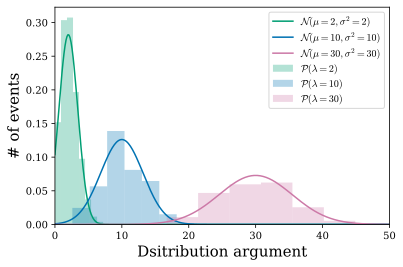

In [26]:
xPoisson = np.linspace(0,60, 400)
plt.hist(np.random.poisson(2,10000) ,alpha = 0.3, color = myColors[0] , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=2)$")
plt.hist(np.random.poisson(10,10000) ,alpha = 0.3, color = myColors[1] , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=10)$")
plt.hist(np.random.poisson(30,10000),alpha = 0.3, color = myColors[2] , bins = 10  , density= True, label = "$\mathcal{P}(\lambda=30)$")
plt.plot(xPoisson,Gaussian(xPoisson, 2, np.sqrt(2)), label = "$\mathcal{N}(\mu =2, \sigma^2 = 2)$")
plt.plot(xPoisson,Gaussian(xPoisson, 10, np.sqrt(10)), label = "$\mathcal{N}(\mu=10, \sigma^2 = 10)$")
plt.plot(xPoisson,Gaussian(xPoisson, 30, np.sqrt(30)), label = "$\mathcal{N}(\mu=30, \sigma^2 = 30) $")

plt.legend( )
plt.xlim(0,50)
plt.xlabel("Dsitribution argument")
plt.ylabel("# of events")

b. First we can create a function that return the expted value for each bins, which will be used in to calculate the $\chi^2$ distribution: $\chi^2=\frac{(\#entries-expactation~value)^2}{expactation~value}$, for each bins.

In [27]:
def bins_expectation(bin_edges,T):
    E = np.empty(len(bin_edges)-1, dtype=object)
    for i in range(len(bin_edges)-1):
        E[i] = integrate.quad(fe, bin_edges[i], bin_edges[i+1], args = (T))[0]
    return E

def chi_squared(bins_entries ,bin_edges, n_sample, T):
    
    f_scaled = n_sample*bins_expectation(bin_edges, T)
    c_squared = 0
    for i in range(len(bin_entries)):
        c_squared += (bin_entries[i]-f_scaled[i])**2/(f_scaled[i])
    return c_squared

In [28]:
n_exp=2000
n_sample=2000

chis = np.empty(n_exp, dtype=object)
n_bins=10

for ii in range(n_exp):
    DataSet = E_generator_2(n_sample, T)
    bin_entries, bin_edges = np.histogram(DataSet, bins=n_bins, density=False)
    chis[ii] = chi_squared(bin_entries, bin_edges, n_sample, T)

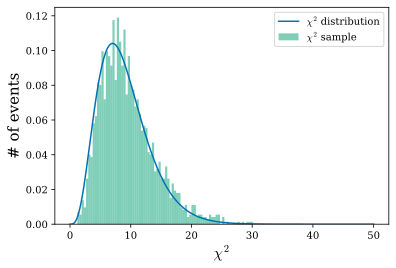

In [29]:
x_fit = np.linspace(0, 50, 1000)
Chi2 = stats.chi2.pdf(x_fit, df = n_bins-1, scale = 1)

plt.hist(chis, density=True, bins=80, alpha=0.5, label = '$\chi^2$ sample')
plt.plot(x_fit, Chi2, label='$\chi^2$ distribution')
plt.xlabel('$\chi^2$')
plt.ylabel('# of events')
plt.legend()



c.

(0.0, 65.0)

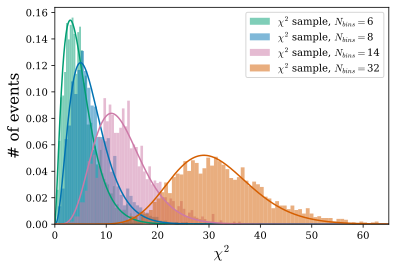

In [30]:
n_exp=2000
n_sample=2000

x_fit = np.linspace(0, 70, 1000)

for i in range(4):
    chis = np.empty(n_exp, dtype=object)
    for ii in range(n_exp):
        n_bins=5+3**i
        DataSet = E_generator_2(n_sample, T)
        bin_entries, bin_edges = np.histogram(DataSet, bins=n_bins, density=False)
        chis[ii] = chi_squared(bin_entries, bin_edges, n_sample, T)
        

    Chi2 = stats.chi2.pdf(x_fit, df = n_bins-1, scale = 1)

    plt.hist(chis, density=True, bins=80, alpha=0.5, label = '$\chi^2$ sample, $N_{bins}=$'+f'{n_bins}', color=myColors[i])
    plt.plot(x_fit, Chi2, color=myColors[i])

plt.xlabel('$\chi^2$')
plt.ylabel('# of events')
plt.legend()
plt.xlim(0, 65)

Task - 4
a.

In [31]:
n_sample = 5000
DataSet = E_generator_2(n_sample,T)

In [32]:
def LLH(etest,temp=T):
    return -np.log(fe(etest,temp)).sum()

In [33]:
def Likelihoodlizer(DataSet, T_estimate):
    nL = len(T_estimate)
    L = np.empty(nL, dtype=object)
    l = np.empty(nL, dtype=object)
    for i in range(0,nL):
        L[i]=LLH(DataSet, T_estimate[i])

    imin=np.argmin(L)
    Lmin=min(L)

    for i in range(0,nL):
        l[i]=L[i]-Lmin

    i1=0
    i2=0
    for i in range(0,nL-1):
        if l[i]>0.5 and l[i+1]<0.5:
            i1=i
        if l[i]<0.5 and l[i+1]>0.5:
            i2=i

    T_e = round(T_estimate[imin], 1)
    err = round((T_estimate[i2]-T_estimate[i1])/2, 1)
    return T_e, err

In [34]:
LLH(DataSet, T)
T_estimate = np.linspace(27,32,100)
nL = len(T_estimate)
L = np.empty(nL, dtype=object)
l = np.empty(nL, dtype=object)
for i in range(0,nL):
    L[i]=LLH(DataSet, T_estimate[i])

imin=np.argmin(L)
Lmin=min(L)

for i in range(0,nL):
    l[i]=L[i]-Lmin

i1=0
i2=0
for i in range(0,nL-1):
    if l[i]>0.5 and l[i+1]<0.5:
        i1=i
    if l[i]<0.5 and l[i+1]>0.5:
        i2=i

T_e = round(T_estimate[imin], 1)
err = round((T_estimate[i2]-T_estimate[i1])/2, 1)
print ('T=',T_e,'+-', err, 'K')

T= 29.7 +- 0.6 K


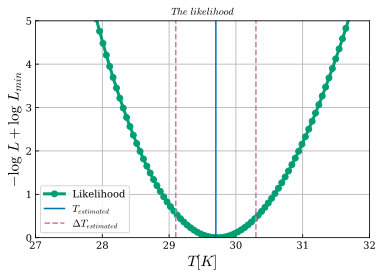

In [35]:
plt.plot(T_estimate,l,'-',lw=3, marker='o', label='Likelihood')
plt.plot((T_e, T_e), (0,12), label='$T_{estimated}$')
plt.plot((T_e+err, T_e+err), (0,12), color = myColors[2], linestyle='--')
plt.plot((T_e-err, T_e-err), (0,12), label='$\Delta T_{estimated}$', linestyle='--', color = myColors[2])

plt.xlabel(r'$T[K]$')
plt.ylabel(r'$-\log{\ L}+\log{\ L_{min}}$')
plt.title(r'$The\ likelihood$')
plt.xlim(27, 32)
plt.ylim(0,5.0)
plt.tick_params(direction='in')
plt.legend()
plt.grid(True)
plt.show()
    

In [36]:
n_exp = 2000
T_estimate = np.linspace(25,35,100)
N = [1000, 1500]

L_T_es = np.empty(len(N), dtype = object)
L_errs = np.empty(len(N), dtype = object)

for n in range(len(N)):
    T_e_llh = np.empty(n_exp, dtype = object)
    err_llh = np.empty(n_exp, dtype = object)
    for i in range(n_exp):
        datas = E_generator_2(N[n], T)
        T_e_llh[i], err_llh[i] = Likelihoodlizer(datas, T_estimate)
    L_T_es[n] = T_e_llh
    L_errs[n] = err_llh


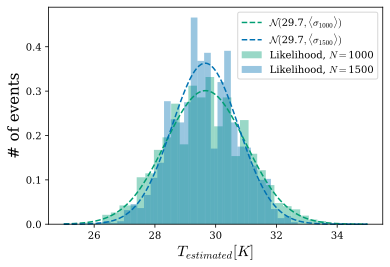

In [37]:
x = np.linspace(25,35,300)
fit_name=[r"$\mathcal{N}($"f"{round(np.mean(L_T_es[0]),1)}"r"$,\langle\sigma_{1000}\rangle)$", r"$\mathcal{N}($"f"{round(np.mean(L_T_es[1]),1)}"r"$,\langle\sigma_{1500}\rangle)$"]
for i in range(len(N)):
    plt.hist(L_T_es[i], bins = 30, density=True, alpha = 0.4, label='Likelihood, $N=$'+f'{N[i]}', color = myColors[i])
    y = Gaussian(x,np.mean(L_T_es[i]),np.mean(L_errs[i]))
    plt.plot(x,y, "--", label =  fit_name[i], color = myColors[i])

plt.xlabel("$T_{estimated}[K]$")
plt.ylabel("# of events")
plt.legend()

b. LeastSquare

In [38]:
def LeastSquare(data, nBins, Ts):

    bin_entries, bin_edges = np.histogram(data, bins = nBins, density=False)
    listX2 =  []
    n_sample = len(data)

    for j in range(len(Ts)):
        c=0
        fj = n_sample*bins_expectation(bin_edges,Ts[j])
        for i in range(len(bin_entries)):
            if(bin_entries[i]==0):
                dif=0
            else:
                dif = (bin_entries[i]-fj[i])**2/bin_entries[i]
                c+=dif
        listX2.append(c)
    return np.array(listX2)

def chi_squared(bins_entries ,bin_edges, n_sample, T):
    
    f_scaled = n_sample*bins_expectation(bin_edges, T)
    c_squared = 0
    for i in range(len(bin_entries)):
        c_squared += (bin_entries[i]-f_scaled[i])**2/(f_scaled[i])
    return c_squared
    
def LS(data, nBins, T):

    bin_entries, bin_edges = np.histogram(data, bins = nBins, density=False)
    yerr = np.sqrt(bin_entries)
    n_sample = len(data)

    chi2 = 0
    fj = n_sample*bins_expectation(bin_edges,T)
    for i in range(len(bin_entries)):
        if(bin_entries[i]==0):
            dif=0
        else:
            dif = np.power((bin_entries[i]-fj[i])/(yerr[i]),2)
            chi2+=dif
    return chi2

[]

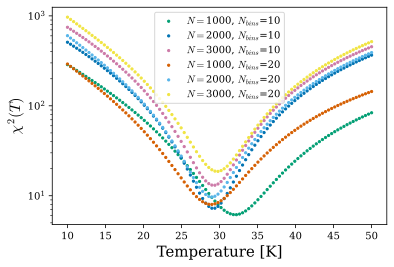

In [39]:
N = [1000, 2000, 3000]
T_estimate = np.linspace(10,50,100)
DS = np.empty(len(N), dtype=object)
LSs = np.empty(len(N), dtype =object)
nbins  =10

for iii in range( 2):
    for i in range(len(N)):
        ds = E_generator_2(N[i], T)
        DS[i] = ds
        ls = np.empty(len(T_estimate), dtype =object)
        for ii in range(len(T_estimate)):
            ls[ii] = LS(ds, nbins*(iii+1), T_estimate[ii])
        LSs[i] =ls
    
        plt.scatter(T_estimate, LSs[i], s=5, label='$N=$'+f'{N[i]}, '+'$N_{bins}$='+f'{nbins*(iii+1)}')
plt.xlabel('Temperature [K]')
plt.ylabel('$\chi^2(T)$')
plt.legend()
plt.semilogy()

In [40]:
def Chi2lizer(DataSet, T_estimate, nbins):
    x2s = LeastSquare(DataSet, nbins, T_estimate)
    imin = np.argmin(x2s)
    x2Min = x2s[imin]
    T_e = T_estimate[imin]

    for i in range(len(x2s)):
        x2s[i] = x2s[i]-x2Min

    i1=0
    i2=0
    for i in range(len(T_estimate)-1):
        if x2s[i]>1 and x2s[i+1]<1:
            i1=i
        if x2s[i]<1 and x2s[i+1]>1:
            i2=i

    err = (T_estimate[i2]-T_estimate[i1])/2
    return T_e, err, x2s

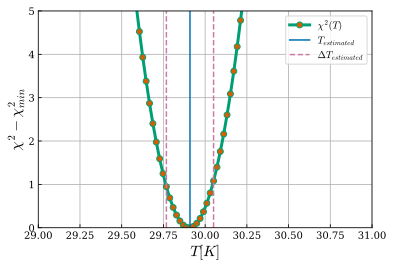

In [73]:
T_estimate = np.linspace(29,31,100)
nbins= 20
DataSet = E_generator_2(100000, T)
T_e, err, x2s = Chi2lizer(DataSet, T_estimate, nbins)

plt.plot(T_estimate,x2s,'-',lw=3, marker='o', label='$\chi^2(T)$', mfc=myColors[3])
plt.plot((T_e, T_e), (0,12), label='$T_{estimated}$')
plt.plot((T_e+err, T_e+err), (0,12), color = myColors[2], linestyle='--')
plt.plot((T_e-err, T_e-err), (0,12), label='$\Delta T_{estimated}$', linestyle='--', color = myColors[2])

plt.xlabel(r'$T[K]$')
plt.ylabel(r'$\chi^2-\chi^2_{min}$')
plt.xlim(29, 31)
plt.ylim(0,5.0)
plt.tick_params(direction='in')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
n_exp = 100
T_estimate = np.linspace(25,35,200)
N = [2000, 2500]

x2_T_es = np.empty(len(N), dtype = object)
x2_errs = np.empty(len(N), dtype = object)
t=[]
for n in range(len(N)):
    
    T_e_x2 = np.empty(n_exp, dtype = object)
    err_x2 = np.empty(n_exp, dtype = object)
    for i in range(n_exp):
        t0      =time.time()
        datas = E_generator_2(N[n], T)
        T_e_x2[i], err_x2[i], _ = Chi2lizer(datas, T_estimate, nbins)
        t.append(time.time()-t0)
        if(i==10):
            print(" Time for 1 loop is approx:", np.mean(t)
                , "\n Comp is finished in ", np.mean(t)*n_exp, "s"
                , " = " , np.mean(t)*n_exp/60 , "min" )
        # print(T_estimate[np.argmin(_)])
    x2_T_es[n] = T_e_x2
    x2_errs[n] = err_x2
    

 Time for 1 loop is approx: 0.8523710207505659 
 Comp is finished in  85.2371020750566 s  =  1.4206183679176099 min
 Time for 1 loop is approx: 0.8290829486675091 
 Comp is finished in  82.90829486675091 s  =  1.3818049144458484 min


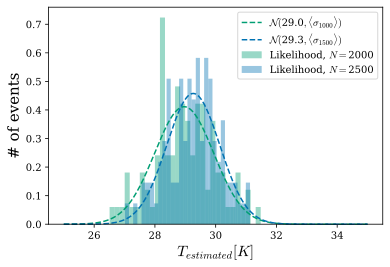

In [71]:
x = np.linspace(25,35,300)
fit_name=[r"$\mathcal{N}($"f"{round(np.mean(x2_T_es[0]),1)}"r"$,\langle\sigma_{1000}\rangle)$", r"$\mathcal{N}($"f"{round(np.mean(x2_T_es[1]),1)}"r"$,\langle\sigma_{1500}\rangle)$"]
for i in range(len(N)):
    plt.hist(x2_T_es[i], bins = 30, density=True, alpha = 0.4, label='Likelihood, $N=$'+f'{N[i]}', color = myColors[i])
    y = Gaussian(x,np.mean(x2_T_es[i]),np.mean(x2_errs[i]))
    plt.plot(x,y, "--", label =  fit_name[i], color = myColors[i])

plt.xlabel("$T_{estimated}[K]$")
plt.ylabel("# of events")
plt.legend()

c. We can also evaluate T with the integrale indeed
$$
E_f= \int_0^{150} e\cdot f(e) de \approx \dfrac{1}{N}\sum_{i=1}^N h(e_i)
$$


In [44]:
n_exp = 1000
N = 5000

In [45]:
M_T_es = np.empty(n_exp, dtype=object)
M_err = np.empty(n_exp, dtype=object)

for i in range(n_exp):
    datas = E_generator_2(N,T)
    MC_est = (1/N)*np.sum(datas)
    MC_var = (1/N)*np.sum(datas**2)-MC_est**2
    MC_std = np.sqrt(MC_var)/np.sqrt(N)
    
    T_est = 2*MC_est
    T_std = 2*MC_std
    M_T_es[i] = T_est
    M_err[i] = T_std

Mean =  29.69728981142692


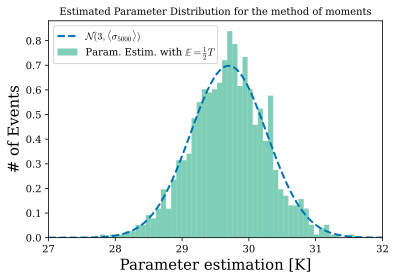

In [46]:
x = np.linspace(27,32,500)
y = Gaussian(x,np.mean(M_T_es),np.mean(M_err))

plt.hist( M_T_es  , bins = 50, density=True, alpha = 0.5, label = "Param. Estim. with "+r"$\mathbb{E}=\frac{1}{2}T$")

plt.plot(x,y, "--", lw = 2, label = r"$\mathcal{N}(3,\langle\sigma_{5000}\rangle)$")
plt.xlim(27,32)

plt.title("Estimated Parameter Distribution for the method of moments")
plt.xlabel("Parameter estimation [K]")
plt.ylabel("# of Events")
plt.legend()

#plt.savefig(path+"MomentDist.png")

print("Mean = ", np.mean(M_T_es))

d. 

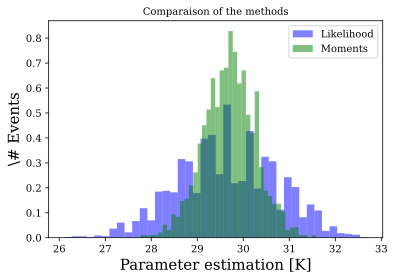

In [64]:
c1,_,_=plt.hist(L_T_es[1], density=True, color="blue"   , alpha=0.5, bins=40, label="Likelihood")
# c2,_,_=plt.hist(x2_T_es[1] , density=True, color="orange"  , alpha=0.5, bins=43, label=r"$\chi^2$")
c3,_,_=plt.hist(M_T_es , density=True, color="green"   , alpha=0.5, bins=40, label="Moments")

plt.title("Comparaison of the methods")
plt.xlabel("Parameter estimation [K]")
plt.ylabel("\# Events")

# plt.xlim(28,31)
plt.legend()

Task - 5


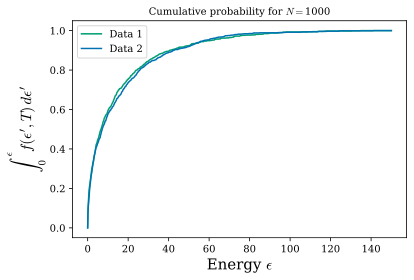

In [48]:
N=1000

data_1 = np.sort(E_generator_2(N,T))  #Generate the data and sort it.
data_2 = np.sort(E_generator_2(N,T))
x = np.linspace(0,150,len(data_1))


# Compute the cumulative function using scipy "percentileofscore"
data_1_cum = [stats.percentileofscore(data_1, i)/100 for i in x]
data_2_cum = [stats.percentileofscore(data_2, i)/100 for i in x]
#print('data_2_cum:\n{}'.format(data_2_cum))
#print(20*'-')

plt.plot(x,data_1_cum, label = "Data 1")
plt.plot(x,data_2_cum, label = "Data 2")

plt.title("Cumulative probability for $N=$"+str(int(N)))
plt.xlabel("Energy $\epsilon$")
plt.ylabel("$\int_0^{\epsilon} f(\epsilon',T) \,d\epsilon'$")
plt.legend()


In [49]:
data_diff = np.abs(np.subtract(data_1_cum, data_2_cum))
max_diff = max(data_diff)

# Trying to use directly the 2-sample Kolmogorov test from scipy.stats:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
# https://stackoverflow.com/questions/39132469/how-to-interpret-scipy-stats-kstest-and-ks-2samp-to-evaluate-fit-of-data-t?rq=1

D_statistics, p_value = stats.ks_2samp(data_1,data_2) #D_statistics is the absolute max distance between the two samples

print("Computed Max Dist\t = "  ,  max_diff
    ,"\nComputed from Libr\t = ", D_statistics)

Computed Max Dist	 =  0.03600000000000003 
Computed from Libr	 =  0.041


In [50]:
#The different values of \alpha and their c(\alpha)

alpha = [0.20, 0.15, 0.10, 0.05, 0.025, 0.01, 0.005, 0.001]
c_alpha = [1.073, 1.138, 1.224, 1.358, 1.628, 1.731, 1.949]

crit_value = []
for i in range(len(alpha)):
    crit = np.sqrt(-math.log(alpha[i]/2)*1/N)
    crit_value.append(np.round(crit,3))

crit_value2 = []
for i in range(len(c_alpha)):
    crit_value2.append(c_alpha[i] * np.sqrt(2/N))

print(crit_value)
print(crit_value2)

[0.048, 0.051, 0.055, 0.061, 0.066, 0.073, 0.077, 0.087]
[0.04798601879714549, 0.05089290716789521, 0.05473894408919485, 0.060731606268894296, 0.07280637334739315, 0.07741267338104273, 0.0871619297629418]


In [51]:
index = 3
if D_statistics > crit_value[index]:
    print('The null hypothesis is rejected at the level:\n{}'.format(alpha[index]))
else : 
    print('We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:\n{}'.format(alpha[index]))

We cannot reject the null hypothesis that the two datasets originate from the same distribution at level:
0.05


In [52]:
# Generalizing for Nexp = 100
N=1000
N_exp = 1e2
i = 1
max_dist =[]
pList = []

while i <= N_exp :     
    data_1 = np.sort(E_generator_2(N,30))
    data_2 = np.sort(E_generator_2(N,30))    
    D_stat, p_value = stats.ks_2samp(data_1, data_2)
    max_dist.append(D_stat)    
    pList.append(p_value)
    i = i+1

In [53]:
# We can compare each of the D_stat value (for each exp) with the 95% confidence level (obtained by using the function we defined before):
# We use the percentileofscore function to see how many (in percentage) are below this value :

print('Crit value for alpha = 0.05 is :\n{}'.format(crit_value[3]))
percentile = stats.percentileofscore(max_dist, crit_value[3])

print('There are', percentile, "% of d <= crit_value : which means that in",percentile , "% of the cases, we cannot reject the null hypothesis that the two datasets originate from the same distribution, at confidence level 95%.")

Crit value for alpha = 0.05 is :
0.061
There are 95.5 % of d <= crit_value : which means that in 95.5 % of the cases, we cannot reject the null hypothesis that the two datasets originate from the same distribution, at confidence level 95%.


Task - 6

In [54]:
def fisher_information(data, T):
    # Initialize the sum
    sum = 0
    delta = 1e-6 
    N=len(data)
    
    # Loop over the data points
    for e in data:
        # Calculate the derivative using finite differences
        derivative = (np.log(fe(e , T+delta)) - np.log(fe(e, T- delta))) / (2 * delta)
        
        # Add the square of the derivative to the sum
        sum += derivative**2
    
    # Return the Fisher information
    return N * sum

In [55]:
n_exp = 1000
n_sample = 1000
fi = np.empty(n_exp, dtype = object)
for i in range(n_exp):
    DataSet = E_generator_2(n_sample, T)
    fi[i] = fisher_information(DataSet, T)


Text(0, 0.5, '# events')

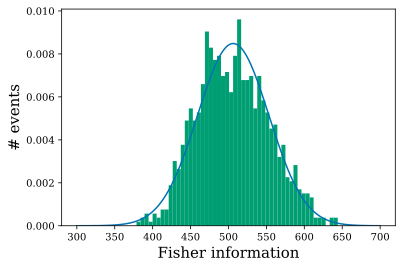

In [56]:
x = np.linspace(300, 700, 1000)
y = Gaussian(x, np.mean(fi), np.sqrt(np.var(fi)))
plt.hist(fi, bins = 50,  density = True)
plt.plot(x, y)
plt.xlabel('Fisher information')
plt.ylabel('# events')


In [61]:
n_exp = 1000

for i in range(n_exp): 
    t0      =time.time()
    d = E_generator_2(1000, 30)
    t.append(time.time()-t0)
    if(i==10):
        print(" Time for 1 loop is approx:", np.mean(t)
            , "\n Comp is finished in ", np.mean(t)*n_exp, "s"
            , " = " , np.mean(t)*n_exp/60 , "min" )




 Time for 1 loop is approx: 0.026167327707464046 
 Comp is finished in  26.167327707464047 s  =  0.4361221284577341 min
